<a href="https://colab.research.google.com/github/lucianosilva-github/paradigmas/blob/main/PARADIGMAS%20-%20AULA%2011%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LINGUAGENS E PARADIGMAS - AULA 10**

**Prof. Luciano Silva**

**OBJETIVOS DA AULA:**

*   Conhecer a evolução histórica das linguagens de programação
*   Conhecer o conceito de Paradigma de Programação
*   Conhecer as características dos paradigmas imperativo, modular, orientado a objetos e funcional
*   Iniciar o processo de compilação de linguagens imperativas (comando condicional)


**O PROBLEMA DO DANGLING ELSE**
Nossa primeira tentativa de implementação do comando condiicional foi com a seguinte modificação na nossa gramática:

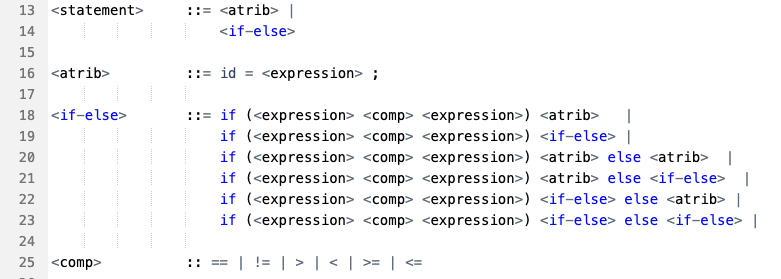

Refatore o analisador léxico, as classes da árvore sintática e o analisador léxico para atender esta modificação:

In [1]:
!pip install rply

* Implementação do analisador léxico:





In [2]:
from rply import LexerGenerator

lg = LexerGenerator()

lg.add('NUMBER', r'\d+')
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'/')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')

lg.add('INT', r'int')
lg.add('STRING', r'string')
lg.add('IF', r'if')
lg.add('ELSE', r'else')

lg.add('ID', r'[a-zA-z][a-zA-z0-9]*')
lg.add('COMP','==')
lg.add('COMP','!=')
lg.add('COMP','>=')
lg.add('COMP','>')
lg.add('COMP','<=')
lg.add('COMP','<')

lg.add('EQUALS', r'=')
lg.add('SEMICOL', r';')

lg.ignore('\s+')

lexer = lg.build()

* Classes dos nós da árvore sintática, já com o método accept para receber os visitors:

In [3]:
#ÁRVORE SINTÁTICA PREPARADA PARA RECEBER VISITORS

from rply.token import BaseBox

class Prog(BaseBox):
    def __init__(self, decls,stmts):
        self.decls = decls
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_prog(self)

class VarDecls(BaseBox):
    def __init__(self, decl,decls):
        self.decl = decl
        self.decls = decls

    def accept(self, visitor):
        visitor.visit_vardecls(self)

class VarDecl(BaseBox):
    def __init__(self, id,tp):
        self.id = id
        self.tp = tp


    def accept(self, visitor):
        visitor.visit_vardecl(self)

class Statements(BaseBox):
    def __init__(self, stmt,stmts):
        self.stmt = stmt
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_statements(self)

class Statement(BaseBox):
    def __init__(self,cmd):
        self.cmd = cmd

    def accept(self, visitor):
        visitor.visit_statement(self)

class Atrib(BaseBox):
    def __init__(self, id,expr):
        self.id = id
        self.expr = expr

    def accept(self, visitor):
        visitor.visit_atrib(self)

class IfElse(BaseBox):
    def __init__(self, expr1, comp, expr2, ie1,ie2):
        self.expr1=expr1
        self.comp = comp
        self.expr2=expr2
        self.ie1=ie1
        self.ie2=ie2

    def accept(self, visitor):
        visitor.visit_ifelse(self)


class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        visit(self)

class Id(Expr):
    def __init__(self, value):
        self.value = value

class Number(Expr):
    def __init__(self, value):
        self.value = value


class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOp):
  pass


class Sub(BinaryOp):
  pass


class Mul(BinaryOp):
  pass


class Div(BinaryOp):
  pass


* Implementação do analisador sintático:

In [4]:
#ANALISADOR SINTÁTICO

from rply import ParserGenerator

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['NUMBER', 'OPEN_PARENS', 'CLOSE_PARENS',
     'PLUS', 'MINUS', 'MUL', 'DIV', 'INT', 'STRING', 'ID','SEMICOL',
     'EQUALS','COMP','IF','ELSE'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])
    ]
)

@pg.production('prog : vardecls statements')
def prog(p):
    return Prog(p[0],p[1])

@pg.production('vardecls : vardecl')
def vardecls(p):
    return VarDecls(p[0],None)

@pg.production('vardecls : vardecl vardecls')
def vardecls(p):
    return VarDecls(p[0],p[1])

@pg.production('vardecl : STRING ID SEMICOL')
def vardecl_string(p):
    return VarDecl(p[1].getstr(), "string")

@pg.production('vardecl : INT ID SEMICOL')
def vardecl_int(p):
    return VarDecl(p[1].getstr(), "int")

@pg.production('statements : statement')
def statements_statement(p):
    return Statements(p[0],None)

@pg.production('statements : statement statements')
def statement_statements(p):
    return Statements(p[0],p[1])

@pg.production('statement : atrib')
def statement_atrib(p):
    return Statement(p[0])

@pg.production('statement : if-else')
def statement_ifelse(p):
    return Statement(p[0])


@pg.production('atrib : ID EQUALS expression SEMICOL')
def atrib(p):
    return Atrib(p[0].getstr(),p[2])

@pg.production('if-else : IF OPEN_PARENS expression COMP expression CLOSE_PARENS atrib')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],None)

@pg.production('if-else : IF OPEN_PARENS expression COMP expression CLOSE_PARENS if-else')
def expression_ifelse2(p):
    return IfElse (p[2],p[3],p[4],p[6],None)

@pg.production('if-else : IF OPEN_PARENS expression COMP expression CLOSE_PARENS atrib ELSE atrib')
def expression_ifelse3(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])

@pg.production('if-else : IF OPEN_PARENS expression COMP expression CLOSE_PARENS atrib ELSE if-else')
def expression_ifelse4(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])

@pg.production('if-else : IF OPEN_PARENS expression COMP expression CLOSE_PARENS if-else ELSE atrib')
def expression_ifelse5(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])

@pg.production('expression : ID')
def expression_id(p):
    return Id(p[0].getstr())

@pg.production('expression : NUMBER')
def expression_number(p):
    return Number(int(p[0].getstr()))

@pg.production('expression : OPEN_PARENS expression CLOSE_PARENS')
def expression_parens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MUL expression')
@pg.production('expression : expression DIV expression')
def expression_binop(p):
    left = p[0]
    right = p[2]
    if p[1].gettokentype() == 'PLUS':
        return Add(left, right)
    elif p[1].gettokentype() == 'MINUS':
        return Sub(left, right)
    elif p[1].gettokentype() == 'MUL':
        return Mul(left, right)
    elif p[1].gettokentype() == 'DIV':
        return Div(left, right)
    else:
        raise AssertionError('Oops, this should not be possible!')

parser = pg.build()

<ipython-input-4-67a80be33eb1>:110: ParserGeneratorWarning: 2 shift/reduce conflicts
  parser = pg.build()


Isto gerou 2 conflitos do tipo shitf-reduce devido ao problema do **dangling else** (**else perdido**). Abaixo, temos um exemplo de onde este problema ocorre:

if (...)

  if (...)

  else ...

A priori, o compilador não consegue identificar de quem é o else, se pertence ao primeiro if ou ao segundo. Em grande parte das linguagens de programação, o assunto é resolvido assumindo-se que o else sempre pertence ao último if, exceto nos casos delimitados por blocos.